In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Rutas a las carpetas de entrenamiento y prueba para imágenes y máscaras
train_frames_dir = 'G:/Unidades compartidas/Reto IA/IA - Reto 2/inputs/train/frames'
train_masks_dir = 'G:/Unidades compartidas/Reto IA/IA - Reto 2/inputs/train/masks'
test_frames_dir = 'G:/Unidades compartidas/Reto IA/IA - Reto 2/inputs/test/frames'
test_masks_dir = 'G:/Unidades compartidas/Reto IA/IA - Reto 2/inputs/test/masks'

# Función para cargar y preprocesar una imagen
def load_image(file_path):
    # Cargar la imagen utilizando OpenCV (cv2)
    image = cv2.imread(file_path, cv2.IMREAD_COLOR)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Realizar preprocesamiento (por ejemplo, redimensionar y normalizar)
    image = image / 255.0  # Normalizar los valores de píxeles al rango [0, 1]

    return image

# Función para cargar y preprocesar una máscara
def load_mask(file_path):
    # Cargar la máscara utilizando OpenCV (cv2)
    mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Realizar preprocesamiento (por ejemplo, redimensionar y normalizar)
    mask = mask / 255.0  # Normalizar los valores de píxeles al rango [0, 1]

    return mask

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Obtener listas de archivos de imagen y máscara en los directorios de entrenamiento y prueba
train_image_files = [os.path.join(train_frames_dir, filename) for filename in os.listdir(train_frames_dir)]
train_mask_files = [os.path.join(train_masks_dir, filename) for filename in os.listdir(train_masks_dir)]
test_image_files = [os.path.join(test_frames_dir, filename) for filename in os.listdir(test_frames_dir)]
test_mask_files = [os.path.join(test_masks_dir, filename) for filename in os.listdir(test_masks_dir)]



In [5]:
train_image_files = sorted(train_image_files)
train_mask_files = sorted(train_mask_files)
test_image_files = sorted(test_image_files)
test_mask_files = sorted(test_mask_files)

In [6]:
train_images = [load_image(file) for file in train_image_files]
train_masks = [load_mask(file) for file in train_mask_files]
test_images = [load_image(file) for file in test_image_files]
test_masks = [load_mask(file) for file in test_mask_files]

In [7]:
tf.debugging.set_log_device_placement(True)

#Convertir las listas de imágenes y máscaras en tensores de TensorFlow
with tf.device('/CPU:0'):
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

# Opcional: Mezclar y dividir los datos en lotes
train_dataset = train_dataset.shuffle(len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [8]:
len(test_image_files)

2552

In [9]:
len(train_image_files)

14920

In [ ]:
print(train_image_files)
print(train_mask_files)

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, ReLU, Conv2DTranspose

# Definición de la arquitectura U-Net
def unet_model(input_shape=(112, 112, 3)):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)
    conv5 = Conv2D(1024, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4])
    conv6 = Conv2D(512, 3, padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    conv6 = Conv2D(512, 3, padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)
    conv7 = Conv2D(256, 3, padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ReLU()(conv8)
    conv8 = Conv2D(128, 3, padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ReLU()(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ReLU()(conv9)
    conv9 = Conv2D(64, 3, padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ReLU()(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

# Crear el modelo U-Net
model = unet_model()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e, -1)

Physical devices cannot be modified after being initialized -1


In [15]:
num_epochs = 10
history = model.fit(train_dataset, validation_data=test_dataset, epochs=num_epochs)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in devic

In [16]:
evaluation = model.evaluate(test_dataset)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity i

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in de

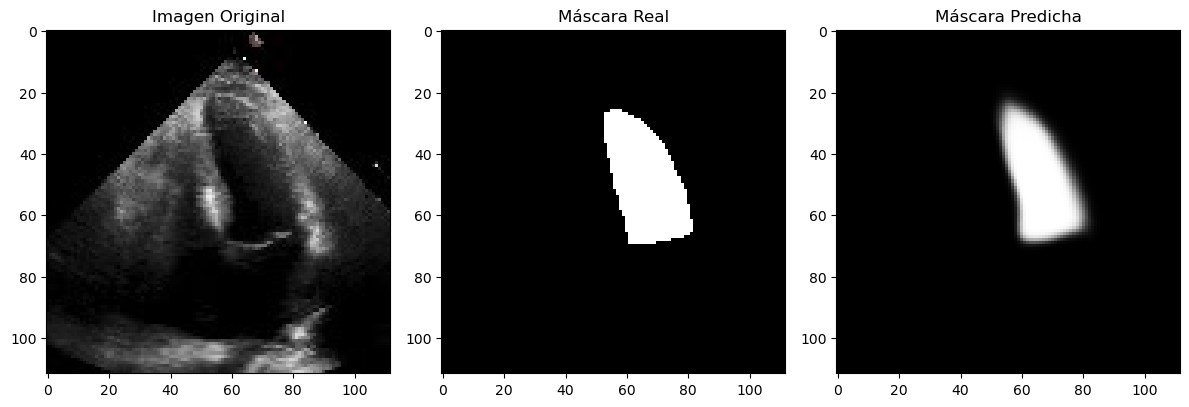

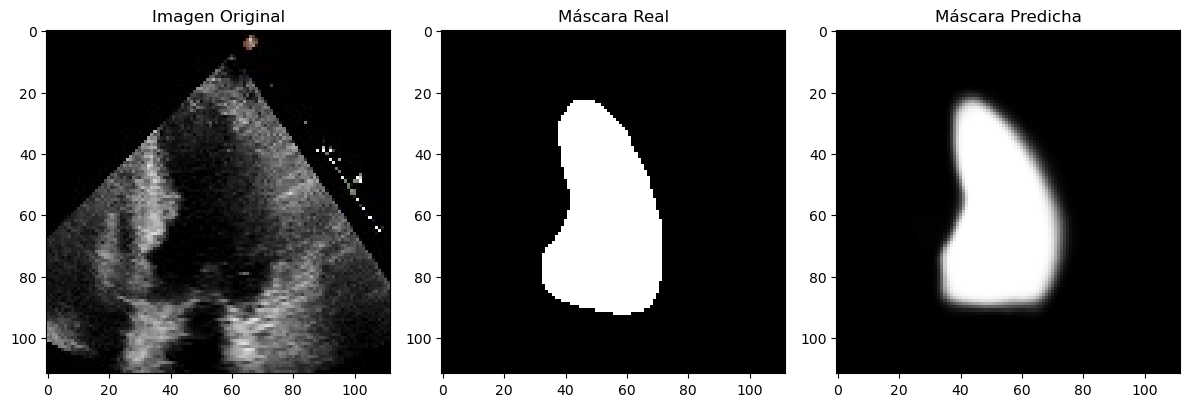

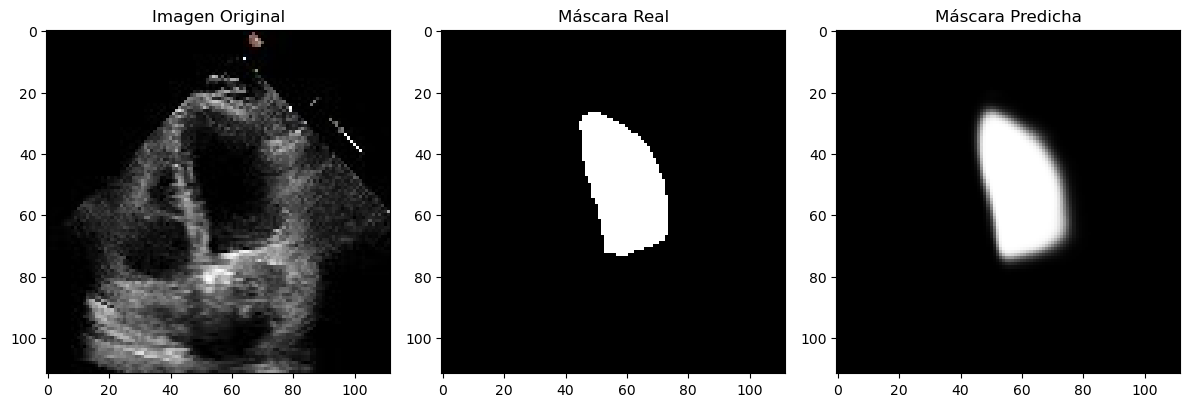

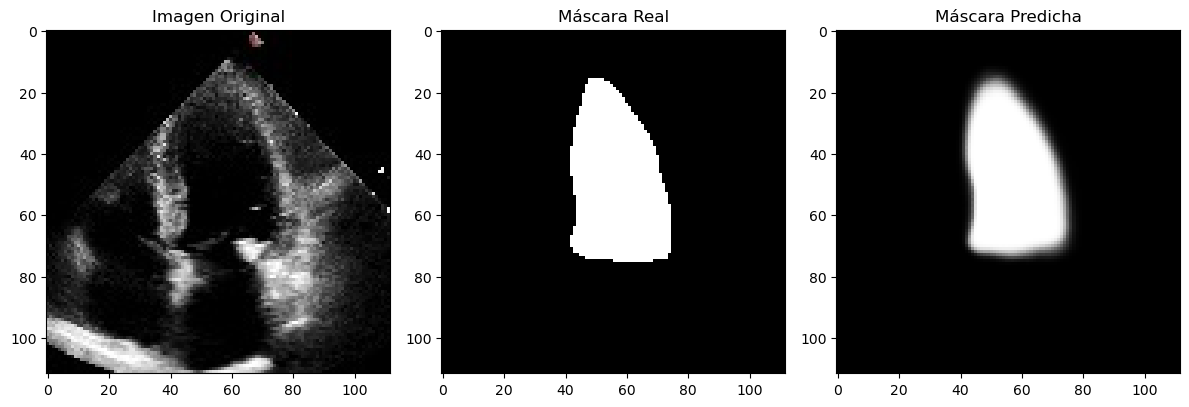

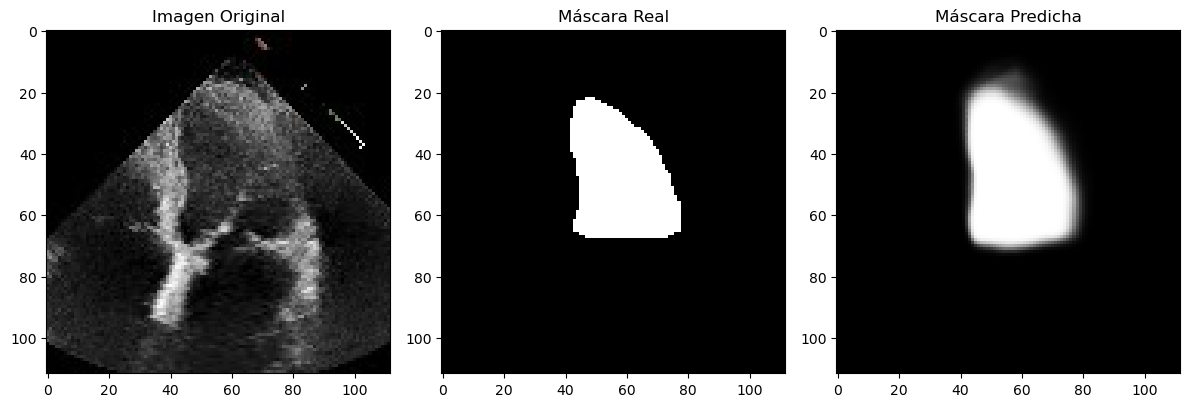

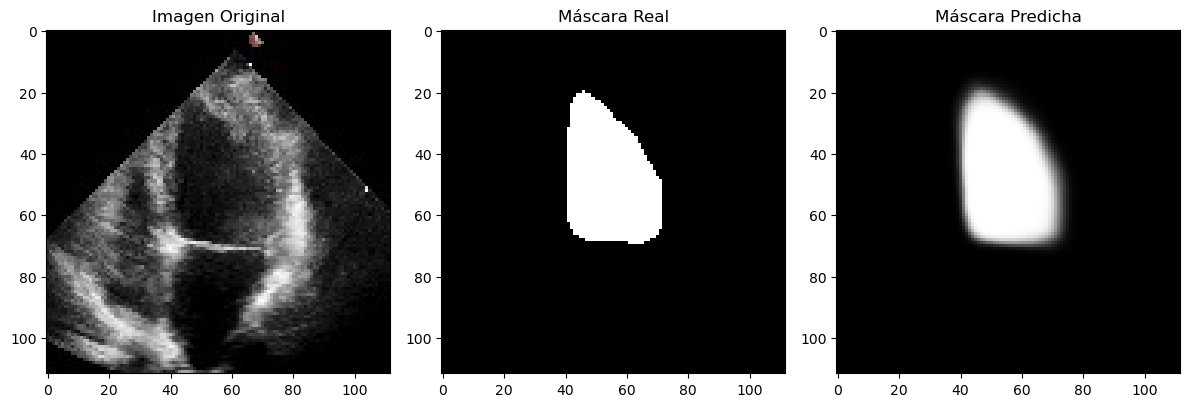

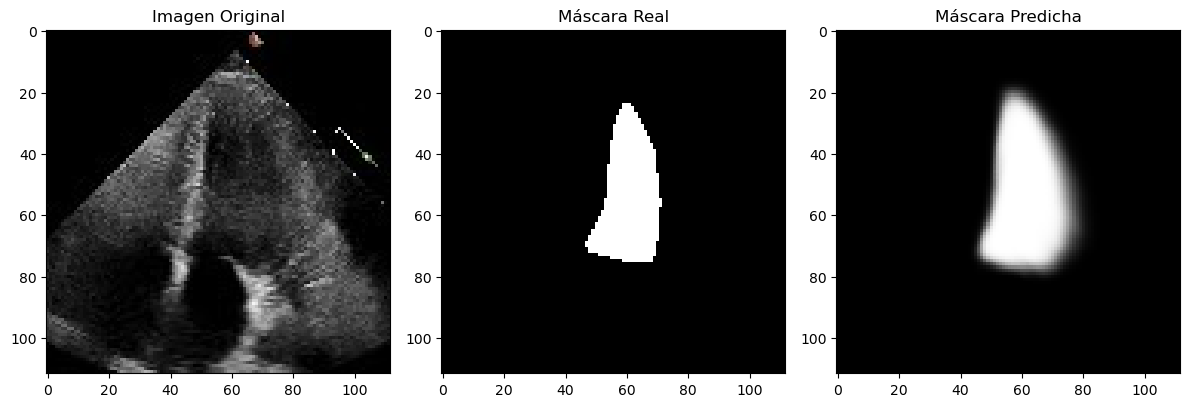

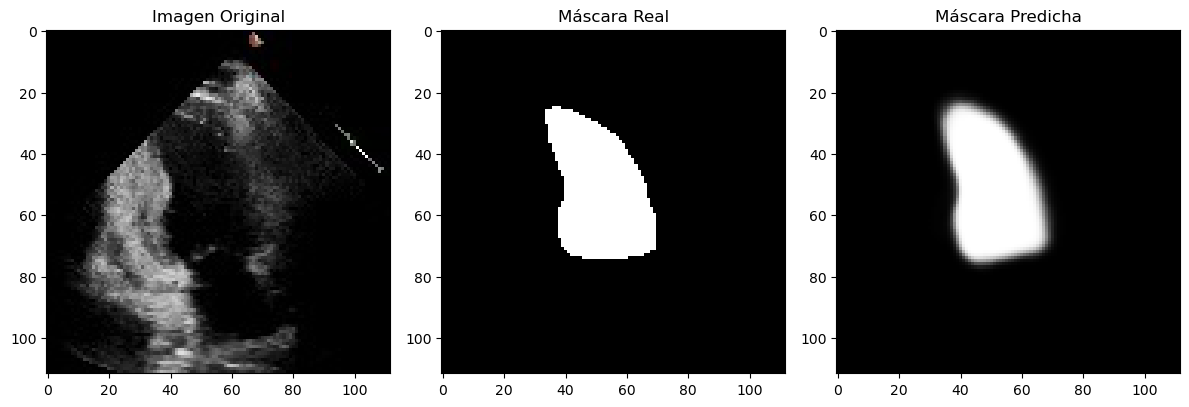

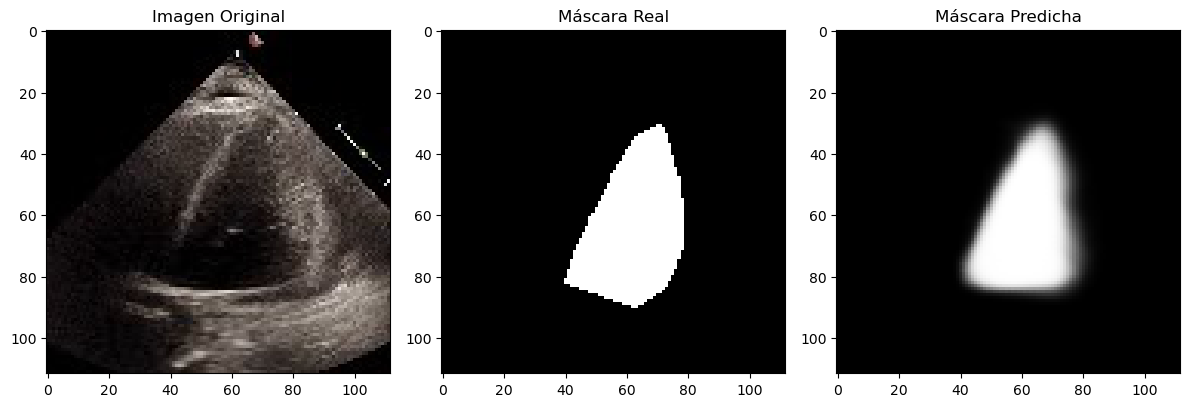

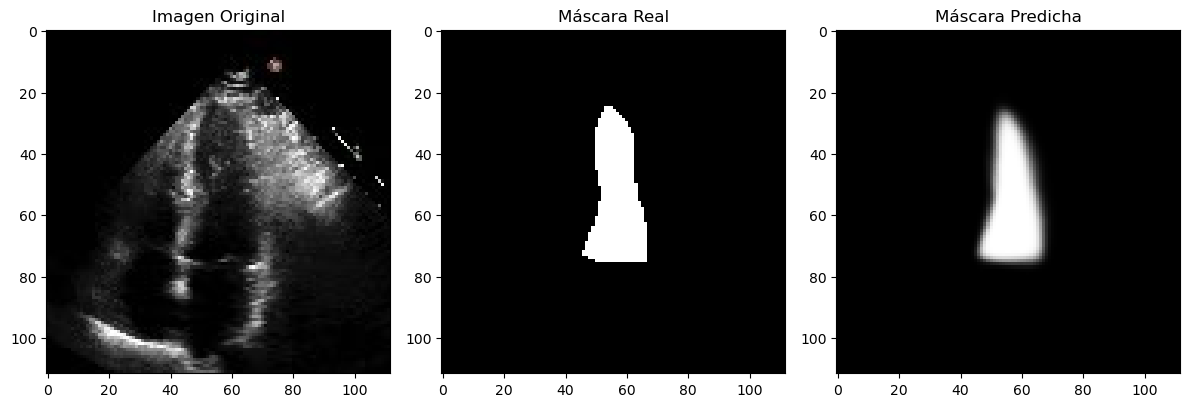

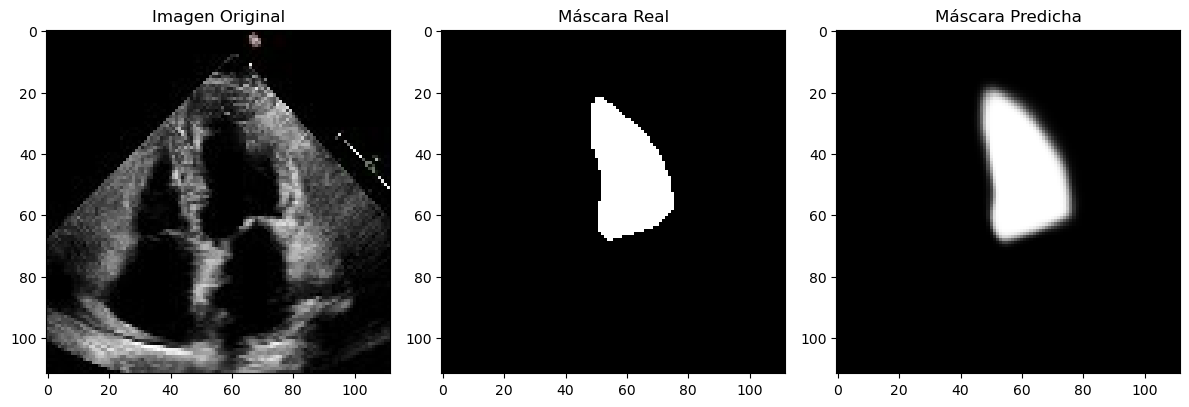

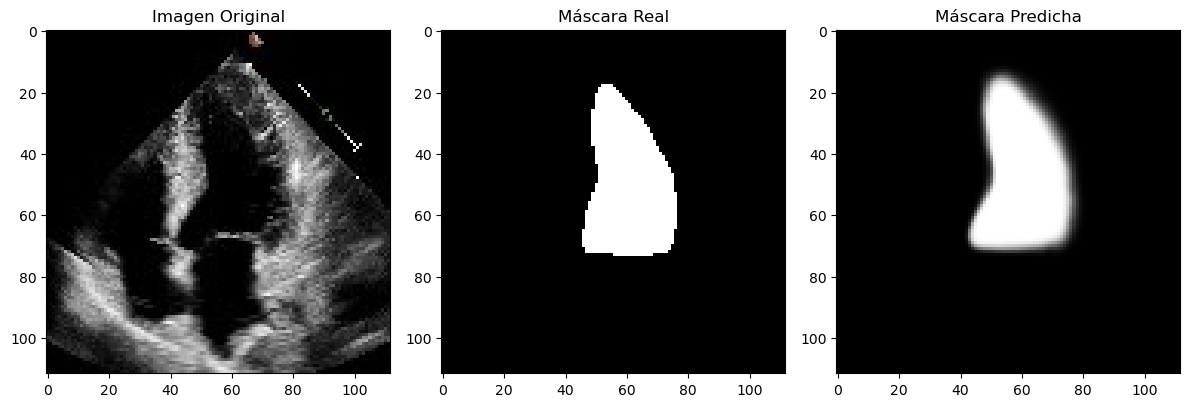

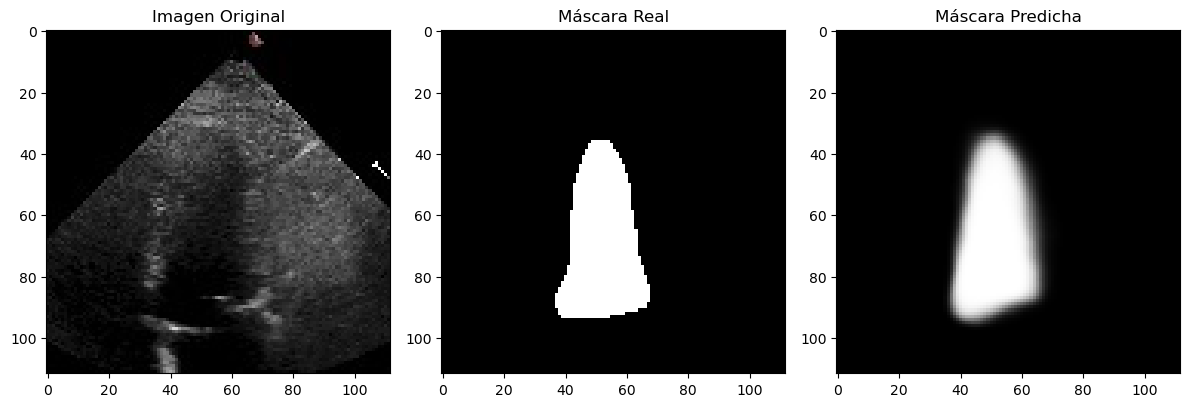

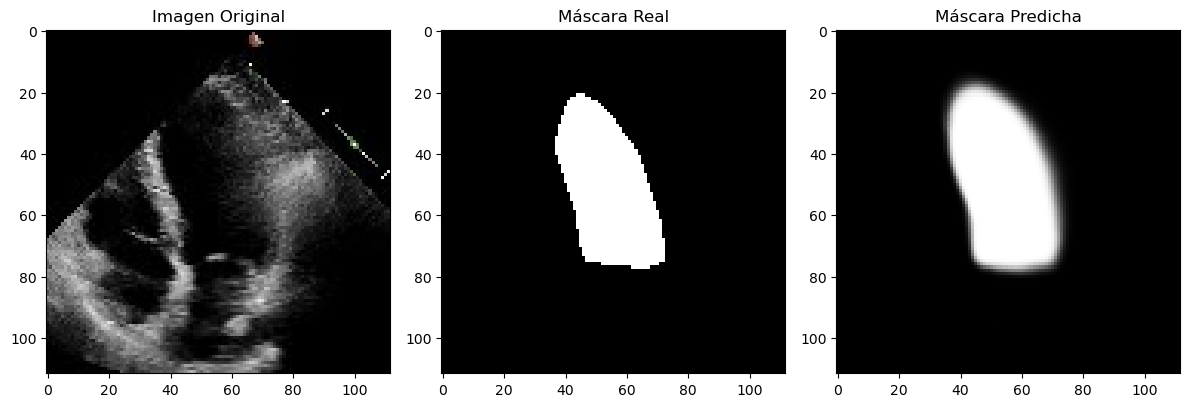

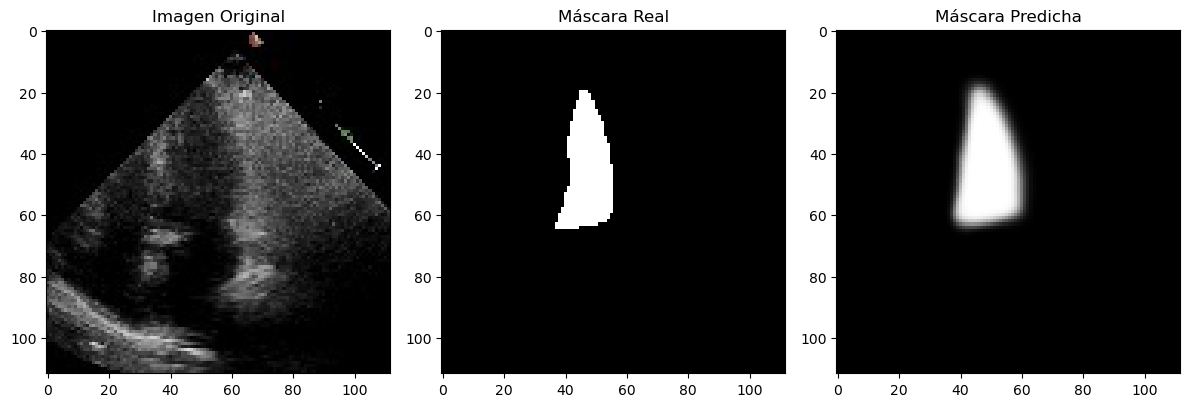

In [17]:

# Función para visualizar una muestra de imágenes y sus máscaras de segmentación predichas
def visualize_segmentation(images, masks, predictions):
    num_samples = len(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 6))

        # Imagen original
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Imagen Original')

        # Máscara de segmentación real
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Máscara Real')

        # Máscara de segmentación predicha
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title('Máscara Predicha')

        plt.tight_layout()
        plt.show()

# Supongamos que tienes un conjunto de datos de prueba con imágenes y máscaras
# Puedes utilizar el modelo para obtener las máscaras predichas en el conjunto de prueba
predictions = model.predict(test_dataset)

# Elije algunas muestras aleatorias para visualizar
num_samples_to_visualize = 15
sample_indices = np.random.choice(len(test_images), num_samples_to_visualize, replace=False)

sample_images = [test_images[i] for i in sample_indices]
sample_masks = [test_masks[i] for i in sample_indices]
sample_predictions = [predictions[i] for i in sample_indices]

# Llama a la función para visualizar las imágenes y máscaras
visualize_segmentation(sample_images, sample_masks, sample_predictions)

